# Step #1 Loading the Data

In [141]:
# Work in progress!

# A tutorial for this file will soon be available at www.relataly.com
# Tested with Python 3.8.8, Matplotlib 3.5, Scikit-learn 0.24.1, Seaborn 0.11.1, numpy 1.19.5, plotly 4.1.1, cufflinks 0.17.3

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from math import log, exp 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})
from scipy.stats import norm
from prophet import Prophet
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'Apple'
symbol = 'AAPL'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Quick overview of dataset
print(df.head())

Installing CmdStan version: 2.31.0
Install directory: C:\Users\Flo\.cmdstan
CmdStan version 2.31.0 already installed


22:14:52 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\Flo\.cmdstan\RTools40


Installing CmdStan version: 2.31.0
Install directory: C:\Users\Flo\.cmdstan
CmdStan version 2.31.0 already installed
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.515212  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.526475  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.422664  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.410790  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.453412  447610800


<AxesSubplot: xlabel='Date', ylabel='Close'>

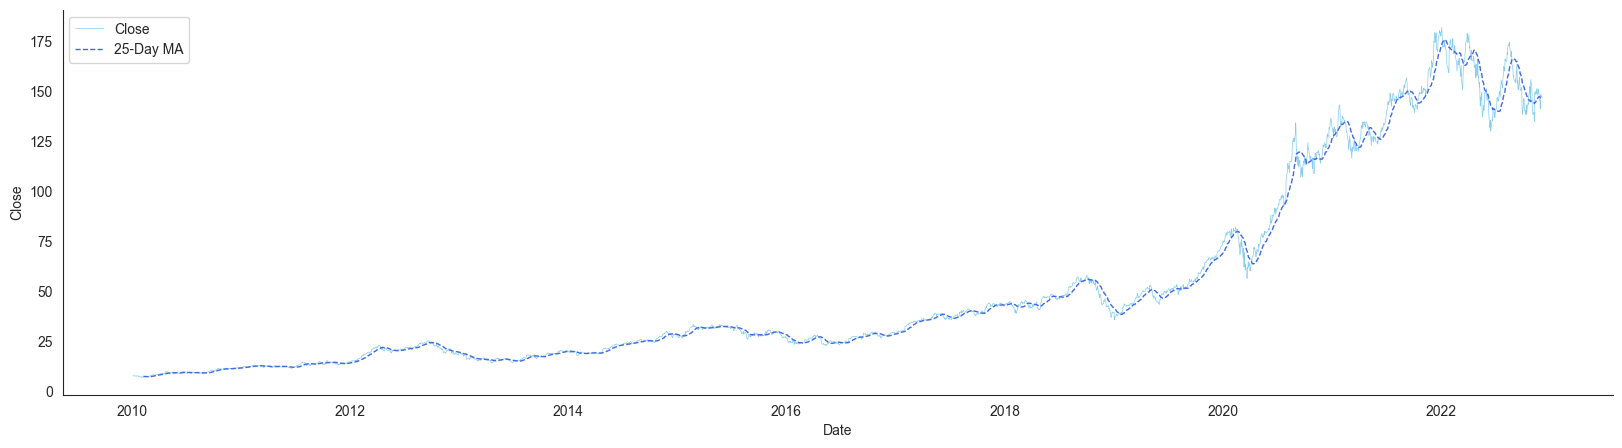

In [142]:
# Visualize the original time series
rolling_window=25
y_a_add_ma = df['Close'].rolling(window=rolling_window).mean() 

fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df, x=df.index, y='Close', color='skyblue', linewidth=0.5, label='Close')
sns.lineplot(data=df, x=df.index, y=y_a_add_ma, 
    linewidth=1.0, color='royalblue', linestyle='--', label=f'{rolling_window}-Day MA')

# Step #2 Prepare the Data

In [153]:
df_x = df[['Close']].copy()
df_x['ds'] = df.index.copy()
df_x.rename(columns={'Close': 'y'}, inplace=True)
df_x.reset_index(inplace=True, drop=True)
df_x.dropna(inplace=True)
df_x.tail(9)

,y,ds
3245,150.179993,2022-11-22
3246,151.070007,2022-11-23
3247,148.110001,2022-11-25
3248,144.220001,2022-11-28
3249,141.169998,2022-11-29
3250,148.029999,2022-11-30
3251,148.309998,2022-12-01
3252,147.809998,2022-12-02
3253,146.630005,2022-12-05


# Step #3 Model Training and Forecasting

22:20:43 - cmdstanpy - INFO - Chain [1] start processing
22:20:43 - cmdstanpy - INFO - Chain [1] done processing


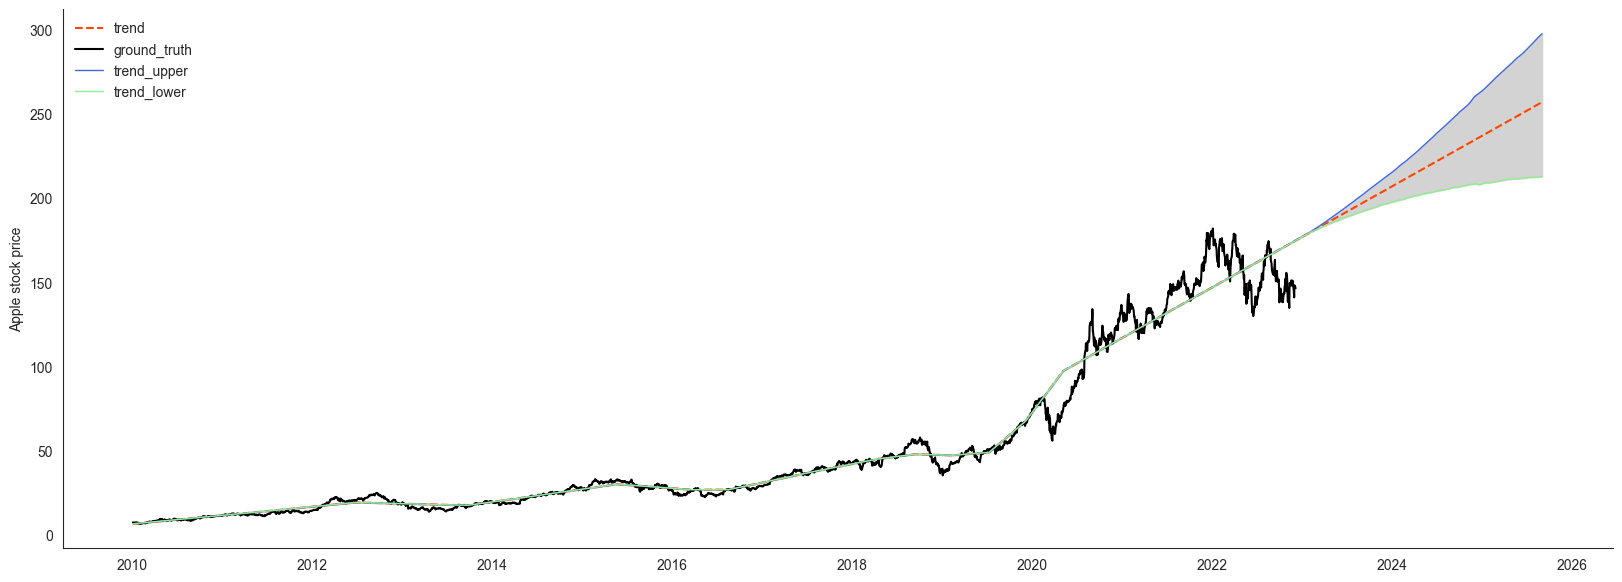

In [160]:
# This function trains the prophet model and generates a forecast
def train_and_forecast(df, periods):
    m = Prophet()
    m.fit(df)

    # Create a dataframe with a given number of dates
    future_df = m.make_future_dataframe(periods=periods)
    future_df.tail()

    # Generate a forecast for the given dates
    forecast_df = m.predict(future_df)
    #print(forecast_df.head())
    return forecast_df

# Visualize the Forecast
def visualize_the_forecast(df_f, df_o):

    # Thin out the ground truth data for illustration purposes
    df_lim = df_o
    # Print the Forecast
    fig, ax = plt.subplots(figsize=[20,7])
    sns.lineplot(data=df_f, x=df_f.ds, y='trend', ax=ax, label='trend', linestyle='--', color='orangered')
    sns.lineplot(data=df_lim, x=df_lim.ds, y='y', ax=ax, label='ground_truth', color='black')
    sns.lineplot(data=df_f, x=df_f.ds, y='trend_upper', ax=ax, label='trend_upper', color='royalblue', linewidth=1.0)
    sns.lineplot(data=df_f, x=df_f.ds, y='trend_lower', ax=ax, label='trend_lower', color='lightgreen', linewidth=1.0)
    plt.fill_between(df_f.ds, df_f.trend_lower, df_f.trend_upper, color='lightgrey')
    plt.legend(framealpha=0)
    ax.set(ylabel=stockname + " stock price")
    ax.set(xlabel=None)

# Forecast for 1000 days with full data
forecast_df = train_and_forecast(df_x, 1000)
visualize_the_forecast(forecast_df, df_x)

22:20:58 - cmdstanpy - INFO - Chain [1] start processing
22:20:59 - cmdstanpy - INFO - Chain [1] done processing


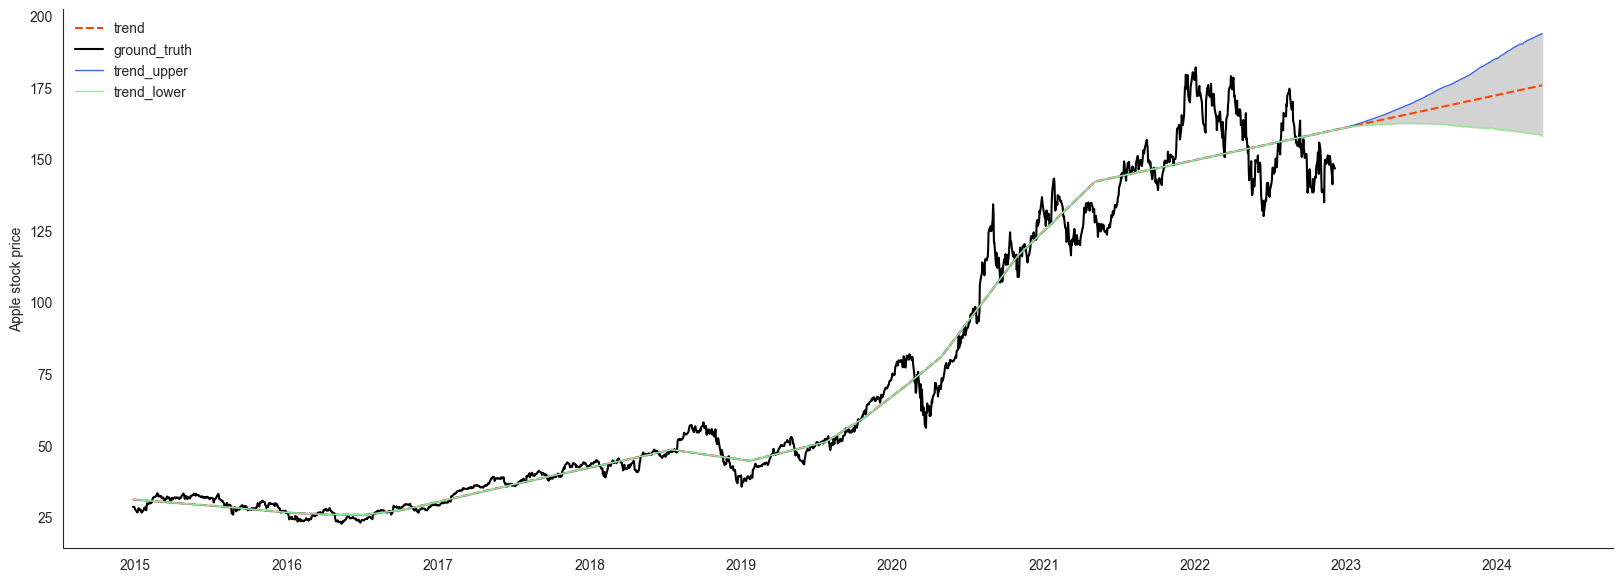

In [161]:
# Forecast for 500 days with 2000 datapoints
training_period = 500 #days
forecast_period = 2000  #days
df_x_lim = df_x[-training_period:]

forecast_df = train_and_forecast(df_x_lim, forecast_period)
visualize_the_forecast(forecast_df, df_x_lim)

22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:57 - cmdstanpy - INFO - Chain [1] done processing


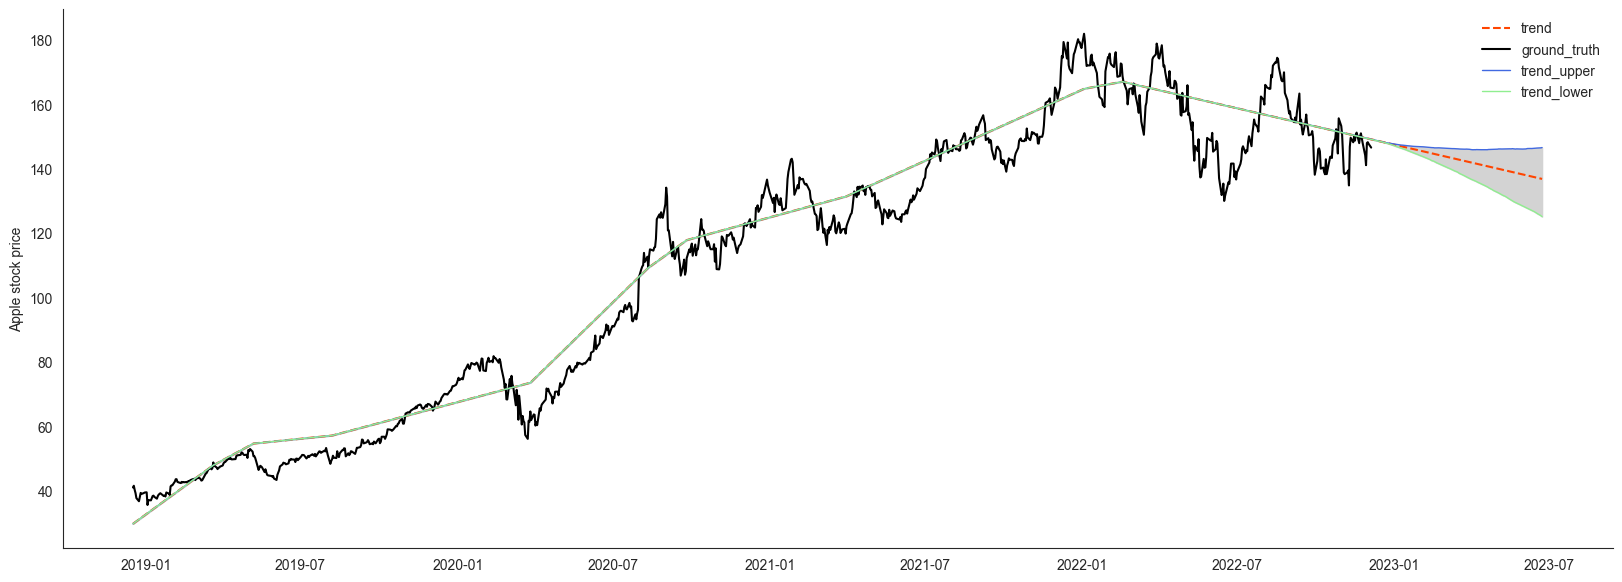

In [166]:
# Forecast for 200 days with 1000 datapoints
training_period = 1000 #days
forecast_period = 200  #days
df_x_lim = df_x[-training_period:]

forecast_df = train_and_forecast(df_x_lim, forecast_period)
visualize_the_forecast(forecast_df, df_x_lim)

22:22:28 - cmdstanpy - INFO - Chain [1] start processing
22:22:28 - cmdstanpy - INFO - Chain [1] done processing


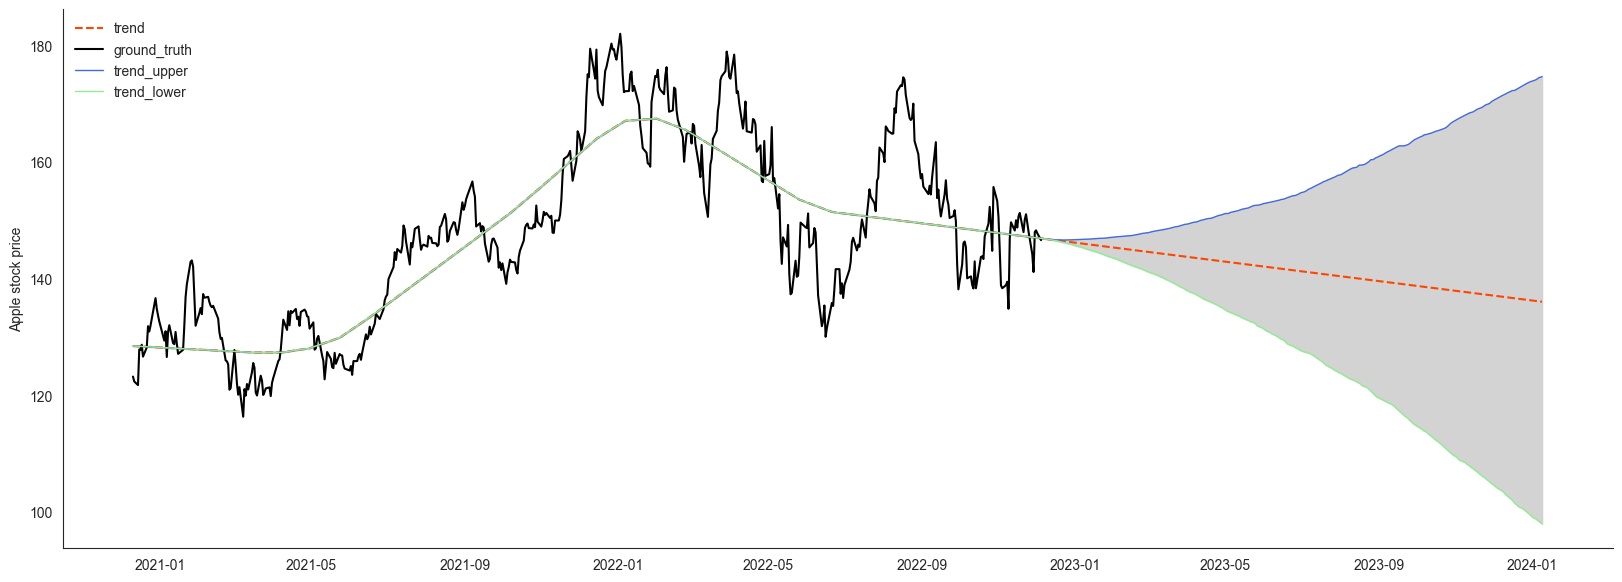

In [165]:
# Forecast for 400 days with 500 datapoints
training_period = 500 #days
forecast_period = 400 #days
df_x_lim = df_x[-training_period:]

forecast_df = train_and_forecast(df_x_lim, forecast_period)
visualize_the_forecast(forecast_df, df_x_lim)